## Audit (2nd July 2023)

Seems like my new quantization schema does work and pruning does work too! Let's try to validate result by decoding in its entirety here.

**Result**
1. File: `output/new_prune_test_3_2x/prune_test_beauty_8_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e801_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/epoch650_ratio0.8900000000000001` to see 
2. Final BPP is good - PSNR is not bad at ~31
    - At 89% prune rate (epoch650_ratio0.8900000000000001): Not bad from 5.8MB to 1.3MB, so just 22.4% of what it was, or a 77% reduction! Still beat HEVC
    - At 94% prune we have (ep799_ratio0.9400000000000001_quant_vid): Went from 5.8 to 1.1MB! Even better, so just 19% of what it was, or a 81% reduction!

Above is not competitive if I look at exact video to compare against on HEVC! Below seems more promising. Actual `Beauty` at ~31 FPS has similar BPP as above, of 0.004344!

1. `/scratch/kl3866/IVP/HNeRV/output/new_prune_test_4_2x/prune_test_beauty_1_MAXVAL128_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e651_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/ep389_ratio0.7500000000000001_quant_vid.pth.br` 
    - compression ratio of 75%; reduces from 5.8MB -> 1.1MB.
    - BPP of 0.01442, so after compression would be 0.002734! 
    - Compared to HEVC would be 0.002734 vs 0.004344 or a `37.1% reduction`!

In [3]:
# brotli -q 11 -o /scratch/kl3866/IVP/HNeRV/output/new_prune_test_4_2x/prune_test_beauty_1_MAXVAL128_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e651_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/ep389_ratio0.7500000000000001_quant_vid.pth.br /scratch/kl3866/IVP/HNeRV/output/new_prune_test_4_2x/prune_test_beauty_1_MAXVAL128_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e651_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/ep389_ratio0.7500000000000001_quant_vid.pth
# brotli -d /scratch/kl3866/IVP/HNeRV/output/new_prune_test_4_2x/prune_test_beauty_1_MAXVAL128_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e651_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/ep389_ratio0.7500000000000001_quant_vid.pth.br -o /scratch/kl3866/IVP/HNeRV/output/new_prune_test_4_2x/prune_test_beauty_1_MAXVAL128_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e651_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/ep389_ratio0.7500000000000001_quant_vid_decompressed.pth


True

In [7]:
import torch
import os
import shutil
from tqdm import tqdm
import argparse
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision.io import write_video

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For reference, below is the quantization function used

In [8]:
def quant_tensor(t):
    
    n_decimal_pos = 2
    MAX_VAL = 128 #max value; also dictate num of bins
    
    t_min = t.min()
    t += abs(t_min) #push to positive
    rounded = torch.round(t * 10**n_decimal_pos) / (10**n_decimal_pos)
    
    print("POST ROUNDED [t]: {} | {}".format(t.max(),t.min()))
    print("POST ROUNDED [rounded]: {} | {}".format(rounded.max(),rounded.min()))
    
    #If all 0 or max is 0; return all 0 directly
    if rounded.max() == 0:
        
        quant_t = {'quant': rounded, 'min': torch.tensor([t_min]), 'scale': torch.tensor([MAX_VAL])}
        
        return quant_t, rounded
    
    q_max = rounded.max()
    rounded = (rounded / q_max) * MAX_VAL #scale to 0 to MAX_VAL
    rounded = torch.round(rounded) #no need call explicitly uint8 as it'll cause training error; just round
    
    assert rounded.max() <= MAX_VAL and rounded.min() >= 0, Exception("Error, tensor OOB! Max: {} | Min: {}".format(rounded.max(),rounded.min()))
    
    #Revert for eval
    dequant = (rounded / MAX_VAL) * q_max
    dequant -= abs(t_min)
    
    quant_t = {'quant': rounded, 'min': torch.tensor([t_min]), 'max': torch.tensor([q_max]), 'scale': torch.tensor([MAX_VAL])}

    return quant_t, dequant    

In [9]:
def dequant_tensor(quant_t):
    quant_t, tmin, tmax, scale = quant_t['quant'], quant_t['min'], quant_t['max'], quant_t['scale']
#     new_t = (quant_t / scale.expand_as(quant_t)) * tmax.expand_as(quant_t)
#     new_t -= abs(tmin.expand_as(quant_t))
    new_t = (quant_t / scale) * tmax
    new_t -= abs(tmin)
    
    return new_t

In [10]:
#Set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
#Root 
root = '/scratch/kl3866/IVP/HNeRV/output/new_prune_test_4_2x/prune_test_beauty_1_MAXVAL128_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e651_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/'
ckt_ori = os.path.join(root,'ep389_ratio0.7500000000000001_quant_vid.pth') #this is used as input to brotli for compression
ckt_decomp = os.path.join(root,'ep389_ratio0.7500000000000001_quant_vid_decompressed.pth') #decompressed from brotli

In [12]:
#Make sure exist
os.path.isfile(ckt_ori) and os.path.isfile(ckt_decomp)

True

In [13]:
#Load pth
load_ori = torch.load(ckt_ori, map_location='cpu')
load_decomp = torch.load(ckt_decomp, map_location='cpu')

In [14]:
load_ori.keys()

dict_keys(['embed', 'model'])

In [15]:
load_ori['model']['decoder.0.conv.downconv.weight']['quant'].shape

torch.Size([65, 16, 1, 1])

In [16]:
dequant_tensor(load_ori['model']['decoder.0.conv.downconv.weight']).shape #shape looks correct!

torch.Size([65, 16, 1, 1])

In [17]:
dequant_tensor(load_decomp['model']['decoder.0.conv.downconv.weight']).shape #shape looks correct!

torch.Size([65, 16, 1, 1])

Now let's dequant both the original and decompressed weights

In [18]:
#Dequantize
ori_dequant_weights = [dequant_tensor(v).to(device).ravel() for k,v in load_ori['model'].items()]
decomp_dequant_weights = [dequant_tensor(v).to(device).ravel() for k,v in load_decomp['model'].items()]


#Extract the QUANTIZED version and keep as is for visualization too
ori_quant_weights = [v['quant'].ravel() for k,v in load_ori['model'].items()]
decomp_quant_weights = [v['quant'].ravel() for k,v in load_decomp['model'].items()]

In [19]:
#Reshape
ori_dequant_weights = torch.cat(ori_dequant_weights)
decomp_dequant_weights = torch.cat(decomp_dequant_weights)

ori_quant_weights = torch.cat(ori_quant_weights)
decomp_quant_weights = torch.cat(decomp_quant_weights)

In [20]:
ori_dequant_weights.shape,decomp_dequant_weights.shape

(torch.Size([1492656]), torch.Size([1492656]))

In [21]:
ori_quant_weights.shape, decomp_quant_weights.shape

(torch.Size([1492656]), torch.Size([1492656]))

Shape looks correct too (decoder size is ~1.5M)

Text(0, 0.5, 'Freq')

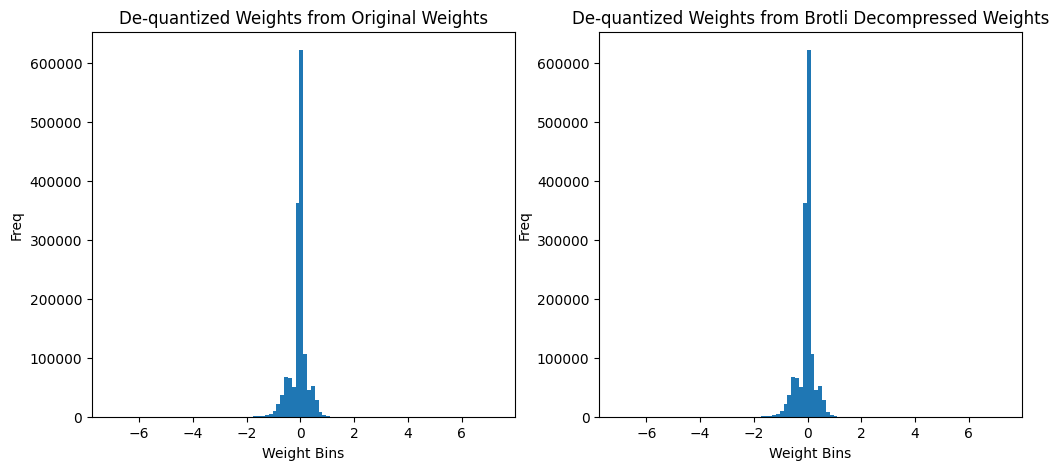

In [22]:
#Plot hist
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(ori_dequant_weights.cpu(),bins=100)
ax[0].title.set_text('De-quantized Weights from Original Weights')
ax[0].set_xlabel('Weight Bins')
ax[0].set_ylabel('Freq')

ax[1].hist(decomp_dequant_weights.cpu(),bins=100)
ax[1].title.set_text('De-quantized Weights from Brotli Decompressed Weights')
ax[1].set_xlabel('Weight Bins')
ax[1].set_ylabel('Freq')

Text(0, 0.5, 'Freq')

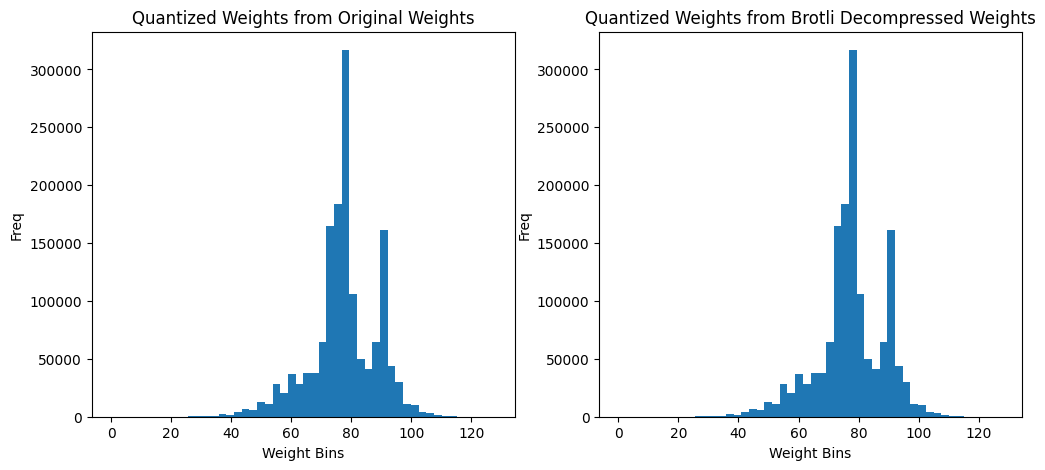

In [23]:
#Plot hist
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(ori_quant_weights.cpu(),bins=50)
ax[0].title.set_text('Quantized Weights from Original Weights')
ax[0].set_xlabel('Weight Bins')
ax[0].set_ylabel('Freq')

ax[1].hist(decomp_quant_weights.cpu(),bins=50)
ax[1].title.set_text('Quantized Weights from Brotli Decompressed Weights')
ax[1].set_xlabel('Weight Bins')
ax[1].set_ylabel('Freq')

Good! Looks like it's properly restored; the quantized and de-quantized weights from the `original` file looks correct too.

Now let's try to reconstruct some frames.

In [27]:
#Dummy arg class 
class argparse():
    
    def __init__(self,decoder,ckt,dump_dir,frames):
        self.decoder = decoder
        self.ckt = ckt
        self.dump_dir = dump_dir
        self.frames = frames

#Init config
args = argparse(decoder='{}/ep389_ratio0.7500000000000001_img_decoder.pth'.format(root),
                ckt='{}/ep389_ratio0.7500000000000001_quant_vid_decompressed.pth'.format(root),
                dump_dir=None,
                frames=3)

#Create output dir if not exist and if defined
if args.dump_dir:
    if not os.path.exists(args.dump_dir):
        os.makedirs(args.dump_dir)

In [28]:
# Load weights into decoder
decomp_dequant_weights = {k:dequant_tensor(v).to(device) for k,v in load_decomp['model'].items()} #dequantize again with proper format

img_decoder = torch.jit.load(args.decoder, map_location='cpu').to(device)
img_decoder.load_state_dict(decomp_dequant_weights)

<All keys matched successfully>

In [29]:
#Dequantize frame embeddings too
vid_embed = dequant_tensor(load_decomp['embed']).to(device)
vid_embed.shape #correct 600 frames 

torch.Size([600, 16, 1, 2])

In [30]:
# Select frame indexs and reconstruct them
frame_step = vid_embed.size(0) // args.frames #Let's look at 3 frames only for sampling
frame_idx = np.arange(0, vid_embed.size(0), frame_step)[:args.frames]

In [31]:
#Decode
img_out = img_decoder(vid_embed[frame_idx])
img_out = img_out.detach().cpu()

In [32]:
img_out.shape #10 frames as specified

torch.Size([3, 3, 960, 1920])

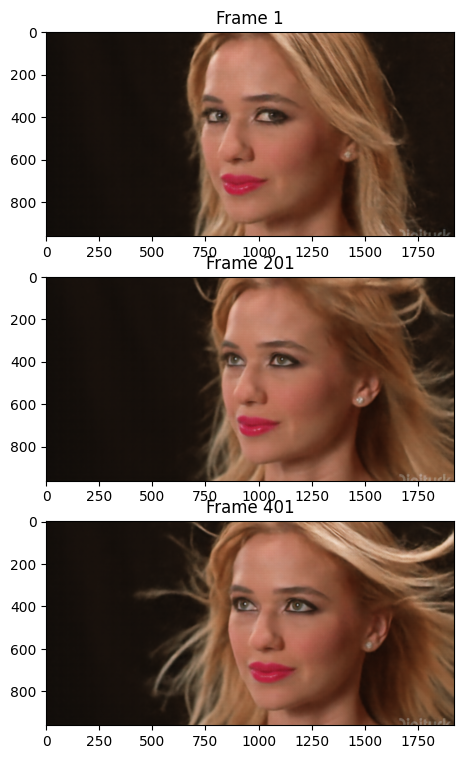

In [33]:
#Show
fig,ax = plt.subplots(3,1,figsize=(12,9))

ax[0].imshow(img_out[0].permute(1,2,0))
ax[0].title.set_text('Frame {}'.format(frame_idx[0]+1))

ax[1].imshow(img_out[1].permute(1,2,0))
ax[1].title.set_text('Frame {}'.format(frame_idx[1]+1))

ax[2].imshow(img_out[2].permute(1,2,0))
ax[2].title.set_text('Frame {}'.format(frame_idx[2]+1))

In [34]:
#Read raw images
raw_img_dir = '/scratch/ar7996/ivp/uvgdataset/Beauty_3840x2160_120fps_420_8bit_YUV_RAW/Beauty_3840x2160_YUV_444_1920x1080_cropped_images/'

In [35]:
#Just read 1 for simplicity
import cv2

img1 = cv2.imread(os.path.join(raw_img_dir,'im00401.png'))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB )

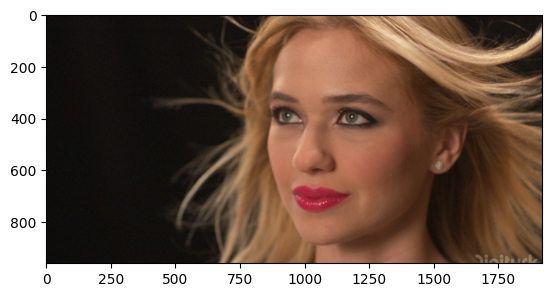

In [36]:
plt.imshow(img1)

In [37]:
#Convert frame to 8bit format first
img0 = img_out[2].permute(1,2,0).numpy()
img0 = (img0 * 255).astype(np.uint8)

#Compute PSNR
psnr_1 = cv2.PSNR(img0, img1)
psnr_1

30.47565764952209

##### Misc / Scribble

In [38]:
import torch.nn.functional as F

#PSNR computation used in HNeRV code
img0 = img_out[2].permute(1,2,0).numpy()
# img0 = ((img0 / img0.max()) * 255)
img0 = torch.tensor(img0)
img0 = img0.permute(2,0,1)[None,...] # to dim of B x C x W x H

img1 = img1 / 255
img1 = torch.tensor(img1.astype(np.float32))
img1 = img1.permute(2,0,1)[None,...]

l2_loss = F.mse_loss(img0, img1,  reduction='none')
psnr = -10 * torch.log10(l2_loss.flatten(start_dim=1).mean(1) + 1e-9)

In [39]:
psnr #much closer but this doesn't seem right

tensor([30.4186])

----

## Audit Results (9th June 2023)
Check
1. Whether quantized models on 32 bit QM with so many zeros can indeed reproduced good PSNR. ❌
2. Whether saved quantized model on 32 bit QM does indeed have primarily >80% zeros. ✅
3. Whether 2x downsampling can improve PSNR on 2x lower resolution. ❌
4. Whether pruning is > quantization in HNeRV. ✅
    - High quantization factor can't be recovered; validate if indeed there is bug in train code.

### Misc
Maybe in this notebook can check if there are other ways to improve results beyond currently seen max PSNR (no quantization) or not.

-----
### Check Quantized

In [49]:
import torch
import os
import shutil
from tqdm import tqdm
import argparse
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision.io import write_video

def dequant_tensor(quant_t):
    quant_t, tmin, scale = quant_t['quant'], quant_t['min'].to(torch.float32), quant_t['scale'].to(torch.float32)
    new_t = tmin.expand_as(quant_t) + scale.expand_as(quant_t) * quant_t
    return new_t

In [50]:
#Establish args

class argparse():
    
    def __init__(self,decoder,ckt,dump_dir,frames):
        self.decoder = decoder
        self.ckt = ckt
        self.dump_dir = dump_dir
        self.frames = frames
        
# parser.add_argument('--decoder', type=str, default='checkpoints/img_decoder.pth', help='path for video decoder',)
# parser.add_argument('--ckt', type=str, default='checkpoints/quant_vid.pth', help='path for video checkpoint',) #
# parser.add_argument('--dump_dir', type=str, default='visualize/bunny_1.5M_E300', help='path for video checkpoint',) #
# parser.add_argument('--frames', type=int, default=16, help='video frames for output',) #

#Init
# root = '/scratch/kl3866/IVP/HNeRV/batches/final/vanilla_HNeRV_gamut/vanilla_Beauty_QTM{qt_model}_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e300_b2_quant_M32_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,3,2,2_DEC_pshuffel_5,4,3,2,2_gelu1_1'
# root ='/scratch/kl3866/IVP/HNeRV/batches/final/8bit_HNeRV_gamut/8bit_HNeRV_gamut/8bit_Beauty_QTM8_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e300_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,3,2,2_DEC_pshuffel_5,4,3,2,2_gelu1_1'
# root = '/scratch/kl3866/IVP/HNeRV/batches/final/2x_1080_HNeRV_gamut/2x_HNeRV_gamut/2x_Beauty_QTM32_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e600_b1_quant_M32_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2_gelu1_1/'

#16 bit 2x
# root = '/scratch/kl3866/IVP/HNeRV/batches/output/2x_16bit_gamut/2x_Beauty_QTM16_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e600_b1_quant_M16_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2_gelu1_1'

#8 bit 2x
# root = '/scratch/kl3866/IVP/HNeRV/batches/output/2x_8bit_gamut/2x_Beauty_QTM8_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e600_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2_gelu1_1'

#24 bit 2x
root = '/scratch/kl3866/IVP/HNeRV/batches/output/2x_24bit_gamut/2x_Beauty_QTM24_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e600_b1_quant_M24_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2_gelu1_1'

args = argparse(decoder='{}/img_decoder.pth'.format(root),
                ckt='{}/quant_vid.pth'.format(root),
                dump_dir=None,
                frames=10)

In [51]:
#Main code | Init
if args.dump_dir:
    if not os.path.exists(args.dump_dir):
        os.makedirs(args.dump_dir)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# Load video checkpoints and dequant them
quant_ckt = torch.load(args.ckt, map_location='cpu')
vid_embed = dequant_tensor(quant_ckt['embed']).to(device)
dequant_ckt = {k:dequant_tensor(v).to(device) for k,v in quant_ckt['model'].items()}
img_decoder = torch.jit.load(args.decoder, map_location='cpu').to(device)
img_decoder.load_state_dict(dequant_ckt)

<All keys matched successfully>

In [121]:
#Check weights
dequant_weights = [dequant_tensor(v).to(device).ravel() for k,v in quant_ckt['model'].items()]
quant_weights = [v['quant'].ravel() for k,v in quant_ckt['model'].items()]

dequant_weights = torch.cat(dequant_weights)
quant_weights = torch.cat(quant_weights)

In [122]:
dequant_weights.shape, quant_weights.shape #correct

(torch.Size([1492656]), torch.Size([1492656]))

Text(0, 0.5, 'Freq')

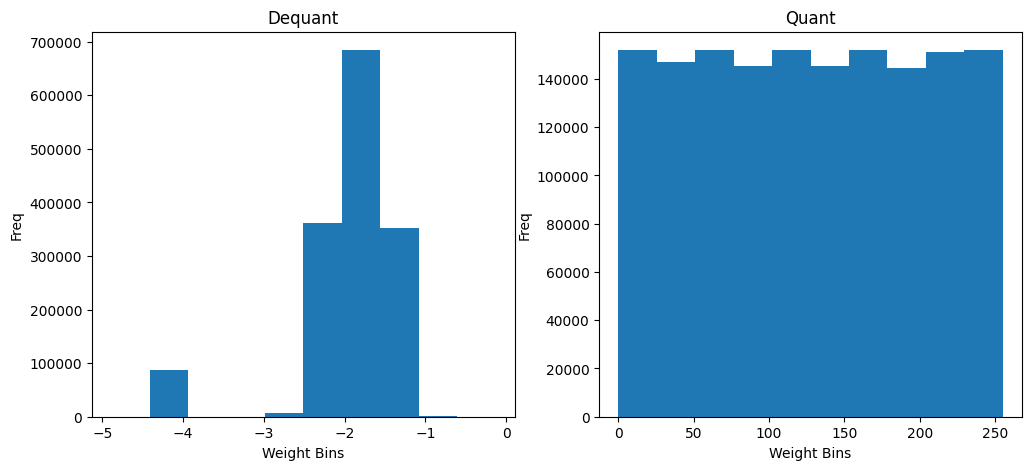

In [123]:
#Plot hist | 24 bit QM on 2x
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(dequant_weights)
ax[0].title.set_text('Dequant')
ax[0].set_xlabel('Weight Bins')
ax[0].set_ylabel('Freq')

ax[1].hist(quant_weights)
ax[1].title.set_text('Quant')
ax[1].set_xlabel('Weight Bins')
ax[1].set_ylabel('Freq')

Text(0, 0.5, 'Freq')

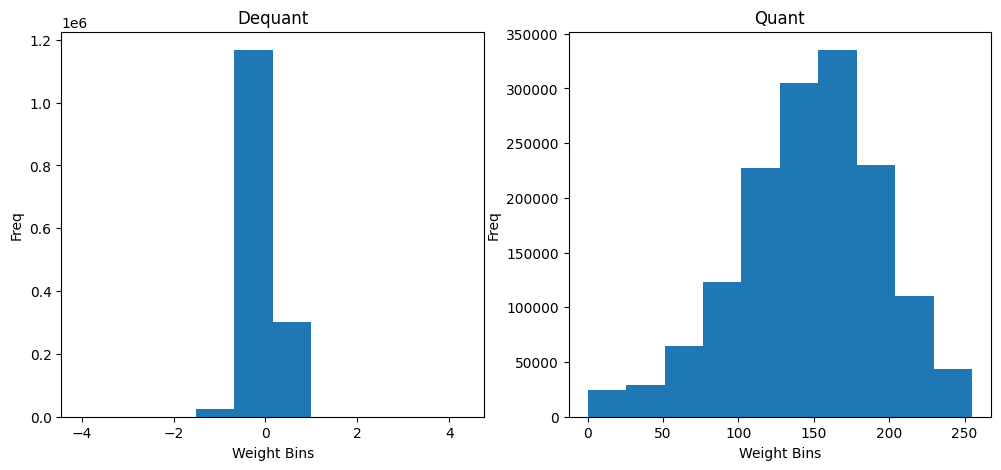

In [114]:
#Plot hist | 8 bit QM on 2x
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(dequant_weights)
ax[0].title.set_text('Dequant')
ax[0].set_xlabel('Weight Bins')
ax[0].set_ylabel('Freq')

ax[1].hist(quant_weights)
ax[1].title.set_text('Quant')
ax[1].set_xlabel('Weight Bins')
ax[1].set_ylabel('Freq')

Text(0, 0.5, 'Freq')

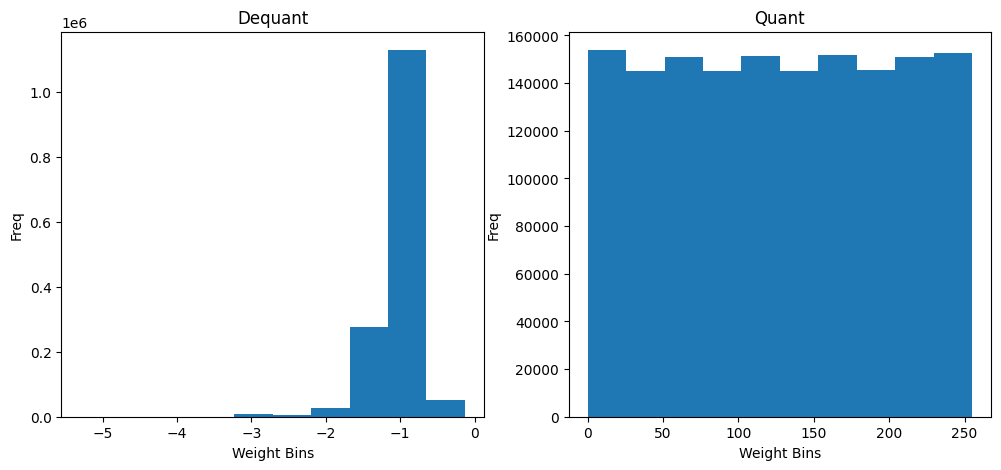

In [105]:
#Plot hist | 16 bit QM on 2x
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(dequant_weights)
ax[0].title.set_text('Dequant')
ax[0].set_xlabel('Weight Bins')
ax[0].set_ylabel('Freq')

ax[1].hist(quant_weights)
ax[1].title.set_text('Quant')
ax[1].set_xlabel('Weight Bins')
ax[1].set_ylabel('Freq')

Text(0, 0.5, 'Freq')

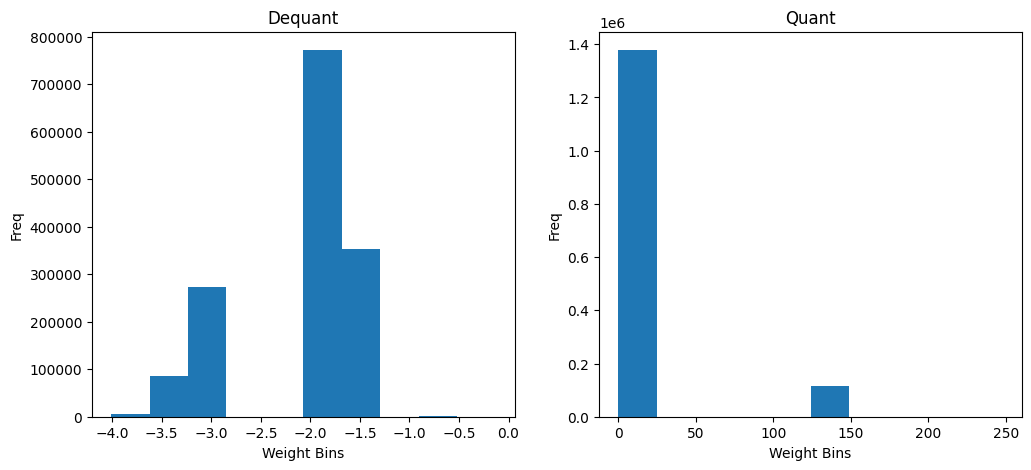

In [26]:
#Plot hist | 32 bit QM on 2x
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(dequant_weights)
ax[0].title.set_text('Dequant')
ax[0].set_xlabel('Weight Bins')
ax[0].set_ylabel('Freq')

ax[1].hist(quant_weights)
ax[1].title.set_text('Quant')
ax[1].set_xlabel('Weight Bins')
ax[1].set_ylabel('Freq')

Text(0, 0.5, 'Freq')

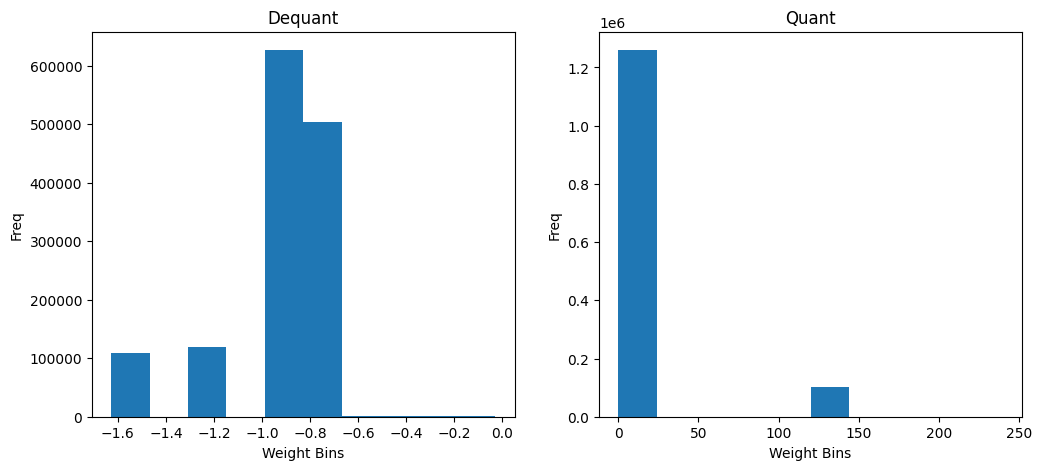

In [17]:
#Plot hist | 32 bit QM
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(dequant_weights)
ax[0].title.set_text('Dequant')
ax[0].set_xlabel('Weight Bins')
ax[0].set_ylabel('Freq')

ax[1].hist(quant_weights)
ax[1].title.set_text('Quant')
ax[1].set_xlabel('Weight Bins')
ax[1].set_ylabel('Freq')

Text(0, 0.5, 'Freq')

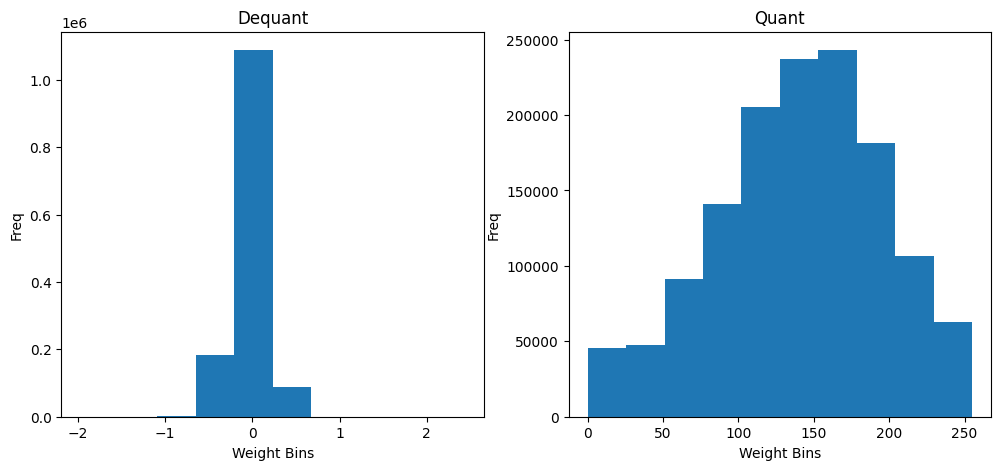

In [8]:
#Plot hist | 8 bit QM
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(dequant_weights)
ax[0].title.set_text('Dequant')
ax[0].set_xlabel('Weight Bins')
ax[0].set_ylabel('Freq')

ax[1].hist(quant_weights)
ax[1].title.set_text('Quant')
ax[1].set_xlabel('Weight Bins')
ax[1].set_ylabel('Freq')

**Note**: It makes sense now! Although quantized has lots of zeros, when it's dequant upon decoding, it's still pretty representative!

In [7]:
vid_embed.shape #600 frames indeed

torch.Size([600, 16, 2, 4])

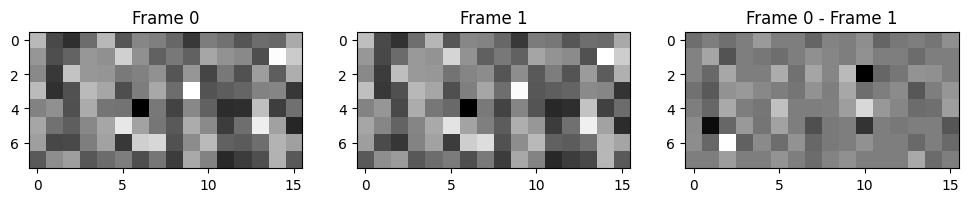

In [35]:
#Let's try to viz a bit out of curiosity
fig,ax = plt.subplots(1,3,figsize=(12,5))

ax[0].imshow(vid_embed[0].reshape(8,16),cmap='gray')
ax[0].title.set_text('Frame 0')

ax[1].imshow(vid_embed[1].reshape(8,16),cmap='gray')
ax[1].title.set_text('Frame 1')

ax[2].imshow(vid_embed[0].reshape(8,16) - vid_embed[1].reshape(8,16),cmap='gray')
ax[2].title.set_text('Frame 0 - Frame 1')

**Note**: Hmm really sparse and the latent embed of each frame is really small, and the delta is not great; perhaps this is why it's hard to capture high frequency details that varies highly across frames quickly. Maybe use positional encoding on latent repr before feeding into decoder during train and infer time?

In [124]:
# Select frame indexs and reconstruct them
frame_step = vid_embed.size(0) // args.frames
frame_idx = np.arange(0, vid_embed.size(0), frame_step)[:args.frames]
img_out = img_decoder(vid_embed[frame_idx]).cpu()


In [125]:
img_out.shape #only specify 10 frames output in argparse

torch.Size([10, 3, 960, 1920])

In [126]:
#Process
final = img_out.permute(0,2,3,1) * 255
final = final.detach().cpu().int()

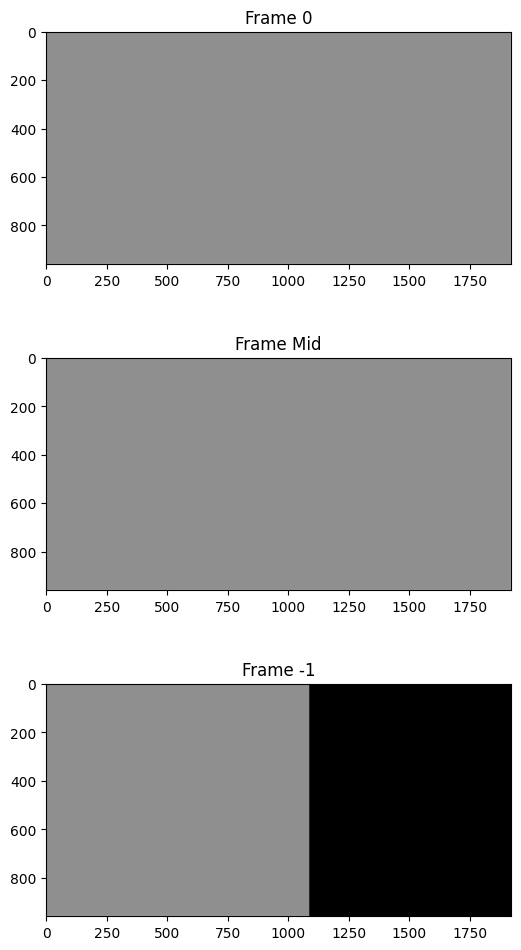

In [127]:
#Viz a few frames
fig,ax = plt.subplots(3,1,figsize=(6,12))

ax[0].imshow(final[0])
ax[0].title.set_text('Frame 0')

ax[1].imshow(final[len(final)//2])
ax[1].title.set_text('Frame Mid')

ax[2].imshow(final[-1])
ax[2].title.set_text('Frame -1')

**Note**: Uh oh, output is not correct for 32bit QM! On 8bit it's okay! I think it's because if we quantized it too much (like 32bit), the dequant weights will be very off and result in bad output. But weird, why did the original code training pipeline not catch this? It should; some bug? Seems like anything beyond QM of 8 bits doesn't work! **Confirm if it's bug in train code when evaluating quantized model**

Regardless, if it's indeed a bug in training code (not here), then
1. Means there's error in reported result and
2. Pruning would be better than quantization indeed

____
### Try Downsample 2x to Compare PSNR

In [147]:
#Get files
root1 ='/scratch/kl3866/IVP/HNeRV/batches/final/8bit_HNeRV_gamut/8bit_HNeRV_gamut/8bit_Beauty_QTM8_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e300_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,3,2,2_DEC_pshuffel_5,4,3,2,2_gelu1_1/visualize_model_orig'
root2 = '/scratch/kl3866/IVP/HNeRV/batches/final/2x_1080_HNeRV_gamut/2x_HNeRV_gamut/2x_Beauty_QTM32_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e600_b1_quant_M32_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2_gelu1_1/visualize_model_orig'

img1_1 = root1 + '/pred_0304_34.2.png'
img2_1 = root2 + '/pred_0304_32.41.png'

In [148]:
#Read img
import cv2

img1_1 = cv2.imread(img1_1)
img1_1 = cv2.cvtColor(img1_1,cv2.COLOR_BGR2RGB)

img2_1 = cv2.imread(img2_1)
img2_1 = cv2.cvtColor(img2_1,cv2.COLOR_BGR2RGB)

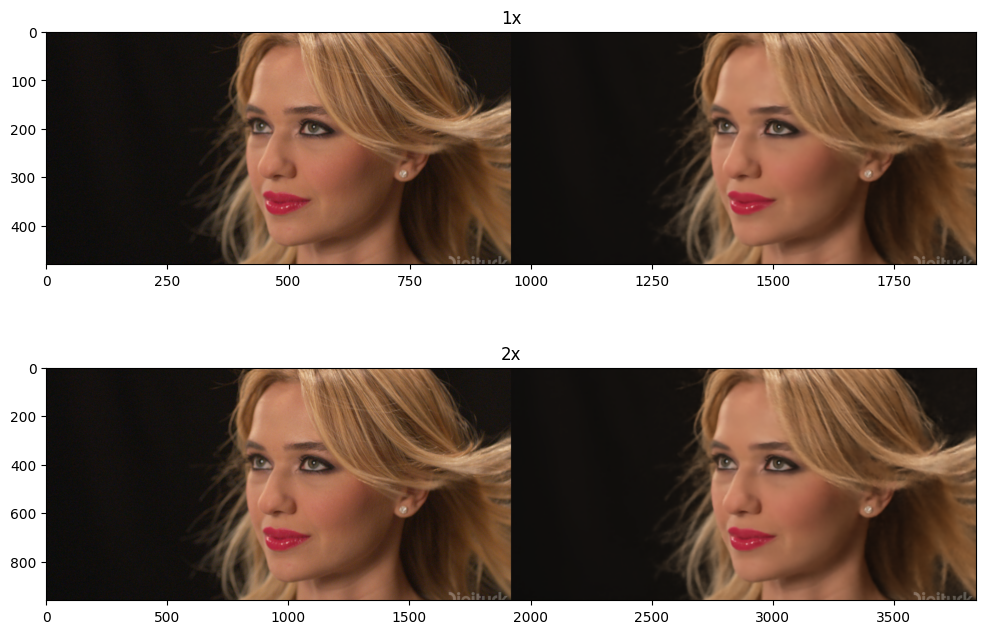

In [150]:
#Let's try to viz a bit out of curiosity
fig,ax = plt.subplots(2,1,figsize=(12,8))

ax[0].imshow(img1_1)
ax[0].title.set_text('1x')

ax[1].imshow(img2_1)
ax[1].title.set_text('2x')

In [188]:
#Crop and compare
h1,w1,_ = img1_1.shape
h2,w2,_ = img2_1.shape

gt = img1_1[:,:w1//2,:]
pred_1x_ori = img1_1[:,w1//2:,:]

gt_2x = img2_1[:,:w2//2,:]
pred_2x = img2_1[:,w2//2:,:]
pred_1x_new = cv2.resize(pred_2x, gt.shape[:-1][::-1], interpolation = cv2.INTER_CUBIC)


In [189]:
#Measure PSNR
cv2.PSNR(gt, gt) #sanity check

361.20199909921956

In [190]:
psnr_gt__pred_1x_ori = cv2.PSNR(gt,pred_1x_ori)
psnr_gt_2x__pred_2x = cv2.PSNR(gt_2x,pred_2x)
psnr_gt__pred_1x_new = cv2.PSNR(gt,pred_1x_new)

In [191]:
psnr_gt__pred_1x_ori,psnr_gt_2x__pred_2x,psnr_gt__pred_1x_new

(34.18918069458045, 32.40317493402679, 34.189955531635114)

**Note**: Doesn't work as expected!